In [15]:
import yfinance as yf
from src import meanReversionTest
import importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

importlib.reload(meanReversionTest)

<module 'src.meanReversionTest' from 'c:\\Users\\jnche\\Desktop\\Personal Projects\\algotrade\\project1_meanReversion\\src\\meanReversionTest.py'>

Download the specified price data using yfinance.

In [16]:
tickers = ['AAPL', 'MSFT']
data = yf.download(tickers, start='2015-01-01', end='2024-01-01', auto_adjust=False)
print(data['Adj Close'].head())
adjCloseData = data['Adj Close']

[*********************100%***********************]  2 of 2 completed

Ticker           AAPL       MSFT
Date                            
2015-01-02  24.237556  39.858456
2015-01-05  23.554752  39.491917
2015-01-06  23.556955  38.912304
2015-01-07  23.887281  39.406677
2015-01-08  24.805079  40.565941


Using simple visualization techniques, see if the selected tickers might possibly be cointegrable.

In the price series plot, we are looking for the tickers to "mirror" each other.

In the scatter plot, we are looking for a relatively linear relationship.

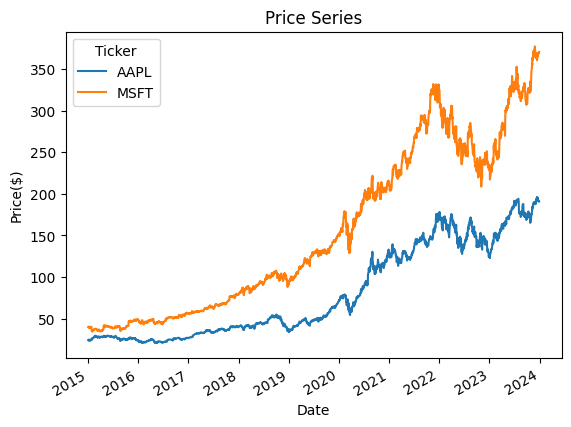

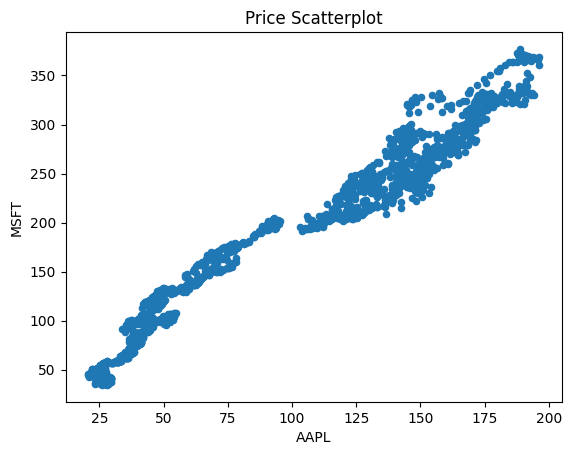

In [17]:
meanReversionTest.plotPriceSeries(adjCloseData)
meanReversionTest.plotScatterSeries(adjCloseData)

Now, we run the CADF test.

First, we fit a linear model to the scatter plot of the two price series.
* This gives us the residuals, along with some other information.
* The residuals are the distance between the predictions of our linear model (using the price series that we set as the independent variable), and the actual price (the other price series that we set as the dependent variable)
* Here, we just choose the price series in the first column of adjCloseData to be the independent variable.

We can plot the residuals to see if, visually, they look like they might be mean reverting.

Finally, we run ADF on the residuals to test if the residuals actually are mean reverting.

c:\Users\jnche\Desktop\Personal Projects\algotrade\project1_meanReversion\src\meanReversionTest.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Residuals'] = res.resid


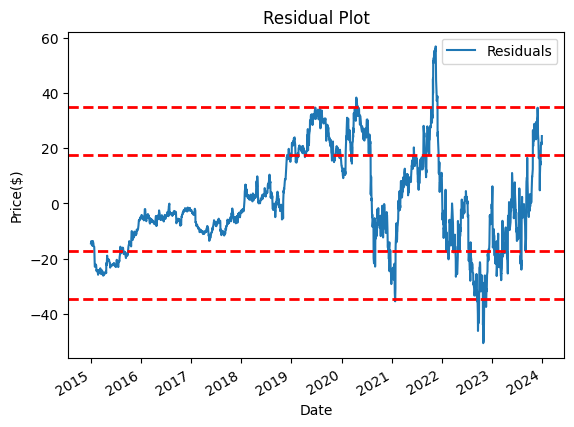

Test statistic: -2.74698326611679
p value: 0.06625495429755596


In [18]:
adjCloseData, beta, intercept = meanReversionTest.fitLinearModel(adjCloseData)
meanReversionTest.plotResiduals(adjCloseData)
testStatistic, pValue, criticalValues = meanReversionTest.doCadf(adjCloseData)

If we determine, based on the test statistic and the p value, that the two price series are cointegrable, we can now specify a linear mean reverting trading strategy and backtest.

First, we calculate the z-score of the spreads/residuals.

In [19]:
spread = adjCloseData['Residuals']
spread = spread.to_numpy()
zscore = (spread - spread.mean()) / spread.std()
print(zscore[:5])

[-0.83377072 -0.78597442 -0.81956704 -0.82443622 -0.85030487]


Then, we backtest.

{'AAPL': 1.7526520229011475, 'MSFT': -1, 'Enter Time': 1330, 'Enter Spread': np.float64(35.17213709247753), 'Exit Time': 1404, 'profitStock1': np.float64(59.131854660559355), 'profitStock2': np.float64(-27.17315673828125), 'Total Profit': np.float64(31.958697922278105), 'Exit Spread': np.float64(3.213439170199422), 'Spread Difference': np.float64(-31.958697922278105)}
{'AAPL': -1.7526520229011475, 'MSFT': 1, 'Enter Time': 1525, 'Enter Spread': np.float64(-35.45628592710233), 'Exit Time': 1532, 'profitStock1': np.float64(15.32094287255543), 'profitStock2': np.float64(12.925018310546875), 'Total Profit': np.float64(28.245961183102303), 'Exit Spread': np.float64(-7.2103247439999905), 'Spread Difference': np.float64(28.245961183102338)}
{'AAPL': 1.7526520229011475, 'MSFT': -1, 'Enter Time': 1717, 'Enter Spread': np.float64(45.112888042295594), 'Exit Time': 1750, 'profitStock1': np.float64(44.11240291624148), 'profitStock2': np.float64(-5.5733642578125), 'Total Profit': np.float64(38.539038

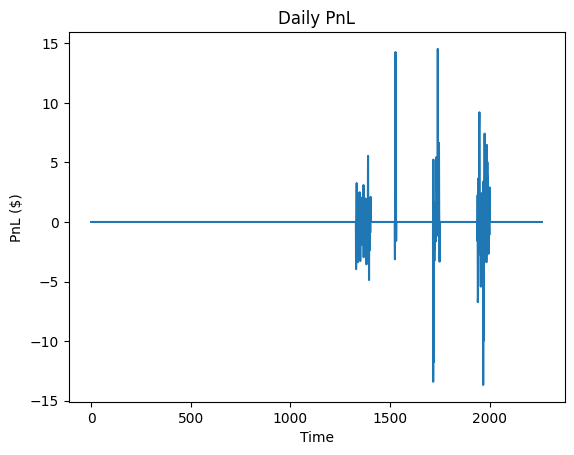

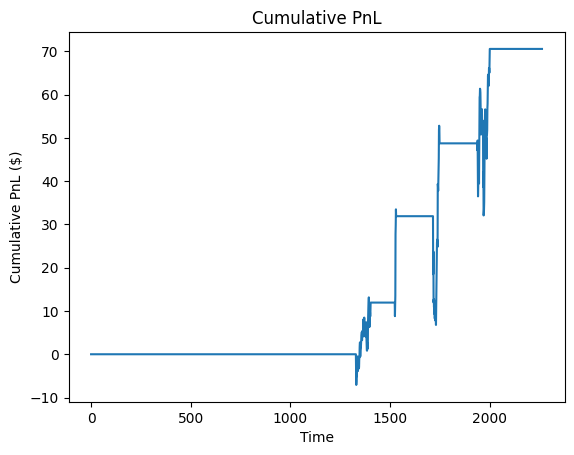

In [27]:
# backtesting code
startingCapital = 1000
headers = list(adjCloseData.columns)
stock1, stock2 = headers[0], headers[1]
currentPosition = dict()
allPositions = []
dailyPnL = []

for t in range(len(zscore)):
    # for now, just work with 1 share of stock 1
    if not currentPosition:
        if zscore[t] > 2:
            # long stock1, short stock2
            currentPosition = {stock1: beta, stock2: -1, 'Enter Time': t, 'Enter Spread': spread[t]}
        elif zscore[t] < -2:
            # short stock1, long stock2
            currentPosition = {stock1: -beta, stock2: 1, 'Enter Time': t, 'Enter Spread': spread[t]}
    else:
        if abs(zscore[t]) < 0.5:
            # exit positions
            if currentPosition:
                # for stock1
                profitStock1 = currentPosition[stock1] * (adjCloseData[stock1].iloc[t] - adjCloseData[stock1].iloc[currentPosition['Enter Time']])
                # for stock2
                profitStock2 = currentPosition[stock2] * (adjCloseData[stock2].iloc[t] - adjCloseData[stock2].iloc[currentPosition['Enter Time']])

                currentPosition['Exit Time'] = t
                currentPosition['profitStock1'] = profitStock1
                currentPosition['profitStock2'] = profitStock2
                currentPosition['Total Profit'] = profitStock1 + profitStock2
                currentPosition['Exit Spread'] = spread[t]
                currentPosition['Spread Difference'] = currentPosition['Exit Spread'] - currentPosition['Enter Spread']

                allPositions.append(currentPosition)
                currentPosition = dict()
    
    # calculate daily PnL
    if currentPosition:
        dailyPnLStock1 = currentPosition[stock1] * (adjCloseData[stock1].iloc[t] - adjCloseData[stock1].iloc[t - 1])
        dailyPnLStock2 = currentPosition[stock2] * (adjCloseData[stock2].iloc[t] - adjCloseData[stock2].iloc[t - 1])
        dailyPnL.append(dailyPnLStock1 + dailyPnLStock2)
    else:
        dailyPnL.append(0)

for i in allPositions:
    print(i)

# plot daily pnl vs time
plt.plot(dailyPnL)
plt.title('Daily PnL')
plt.xlabel('Time')
plt.ylabel('PnL ($)')
plt.show()

# plot cumulative pnl vs time
cumulativePnL = np.cumsum(dailyPnL)
plt.plot(cumulativePnL)
plt.title('Cumulative PnL')
plt.xlabel('Time')
plt.ylabel('Cumulative PnL ($)')
plt.show()

Evaluate performance using:
* Equity curve (cumulative PnL)
* Sharpe ratio
* Max Drawdown
* Number of trades / win rate